In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(patchwork)))
suppressPackageStartupMessages(suppressWarnings(library(cowplot)))
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML)))
suppressPackageStartupMessages(suppressWarnings(library(pheatmap)))
suppressPackageStartupMessages(suppressWarnings(library(lattice)))
suppressPackageStartupMessages(suppressWarnings(library("RColorBrewer")))
suppressPackageStartupMessages(suppressWarnings(library(gplots)))
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap)))
suppressPackageStartupMessages(suppressWarnings(library(ggplotify)))
suppressPackageStartupMessages(suppressWarnings(library(arrow)))
suppressPackageStartupMessages(suppressWarnings(library(scales)))
suppressPackageStartupMessages(suppressWarnings(library(circlize)))
suppressPackageStartupMessages(suppressWarnings(library(Polychrome)))

# check if ggmagnify is installed, if not install it
if (!requireNamespace("ggmagnify", quietly = TRUE)) {
  install.packages("ggmagnify", repos = c("https://hughjonesd.r-universe.dev", 
                 "https://cloud.r-project.org"))
}
suppressPackageStartupMessages(suppressWarnings(library(ggmagnify)))
source("../../utils/figure_themes.r")


## Generate each individual plot priot to combining them in a single figure (pathwork)

In [2]:
# Load in the treatment list
toml_path <- file.path("..","..","..","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
# get the list that is in the toml file under the key "treatments"
# define that list as a variable called list_of_treatments and print the list to verify
list_of_treatments <- c(p$list_of_treatments$treatments)



In [3]:
# Figure 2A

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# filter out the treatments that are not in the list
cytokine_values <- cytokine_values[cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]

# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)



In [4]:
# convert to a dataframe
cytokine_values <- as.data.frame(cytokine_values)
head(cytokine_values,2)

# make a new column that is the treatment group based on the ground truth data
cytokine_values$group <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values$group <- factor(cytokine_values$group, levels = c("Control","Apoptosis", "Pyroptosis"))


,plate_name,plate_barcode,position_x,cell_type,incubation inducer,inhibitor,inhibitor_concentration_value,inhibitor_concentration_unit,inhibitor_concentration,inducer1,⋯,VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Treatment,Dose,oneb_Treatment_Dose_Inhibitor_Dose,twob_Treatment_Dose_Inhibitor_Dose,threeb_Treatment_Dose_Inhibitor_Dose,fourb_Treatment_Dose_Inhibitor_Dose
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,70117_20230210MM1_P1,430420,B06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.2588339,0.2383579,0.5242758,0.2506705,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030
2,70117_20230210MM1_P1,430420,C06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.3811698,0.1686448,0.4550923,0.2287523,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030


In [5]:
# mutate the names of each treatment
cytokine_values <- cytokine_values %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))


In [6]:
# create grouping of treatment and group
cytokine_values$group_treatment <- paste(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose, cytokine_values$group,  sep = ", ")
# make the group_treatment column a factor
cytokine_values$group_treatment <- factor(
    cytokine_values$group_treatment, 
    levels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
    )
)
unique(cytokine_values$group_treatment)

[1] DMSO 0.1%, Control                           
 [2] Flagellin 1.0 ug/ml, Pyroptosis              
 [3] LPS 0.01 ug/ml, Pyroptosis                   
 [4] LPS 0.1 ug/ml, Pyroptosis                    
 [5] Flagellin 0.1 ug/ml, Control                 
 [6] LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis 
 [7] LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis
 [8] LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis 
 [9] LPS 1.0 ug/ml, Pyroptosis                    
[10] Thapsigargin 1.0 uM, Apoptosis               
[11] LPS 10.0 ug/ml, Pyroptosis                   
[12] Thapsigargin 10.0 uM, Apoptosis              
[13] H2O2 100.0 nM, Control                       
[14] LPS 100.0 ug/ml, Pyroptosis                  
[15] H2O2 100.0 uM, Control                       
15 Levels: DMSO 0.1%, Control ... Thapsigargin 10.0 uM, Apoptosis

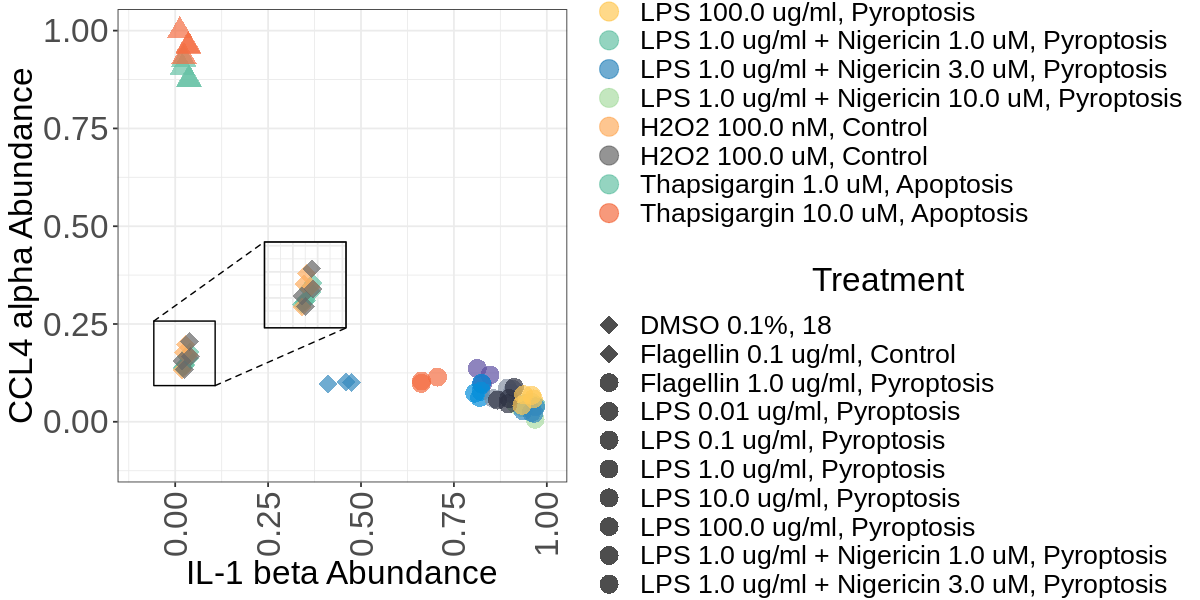

In [7]:
# set plot size
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
cytokine_scatter_plot1 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `CCL24 [NSU]`,
            color = group_treatment,
            shape = group_treatment
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta Abundance")
    + ylab("CCL4 alpha Abundance")
    + xlim(-0.1, 1)
    + ylim(-0.1, 1)
    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
        ),
        values = c(
        '#66c2a5',
        '#3288bd',
        '#f46d43',
        '#5e4fa2',
        "#058ED9",
        "#848FA2",
        "#2D3142",
        "#FFC857",
        '#66c2a5',
        '#3288bd',
        '#abdda4',
        '#fdae61',
        # dark grey
        '#666666',
        # green
        '#66c2a5',
        '#f46d43'
        ))
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%, 18',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
        ),
        values = c(
        18,
        18,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        18,
        18,
        17,
        17
        ))
    

)

options(repr.plot.width=10, repr.plot.height=5)
# cytokine_scatter_plot
from <- list(-0.05, 0.1, 0.1, 0.25) #xmin, xmax, ymin, ymax
to <- list(0.25,0.45, 0.25, 0.45)
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + geom_magnify(
    from = from, to = to
)
cytokine_scatter_plot1


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


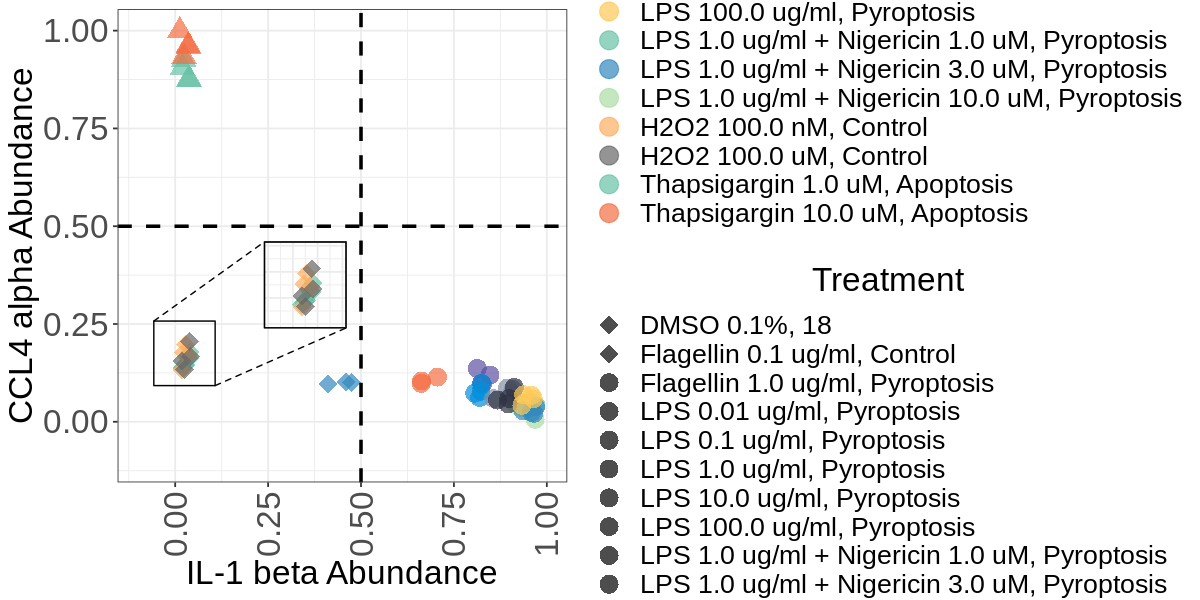

In [8]:
# cytokine_scatter_plot add gates 
cytokine_scatter_plot1 <- (
    cytokine_scatter_plot1
    + geom_vline(xintercept = 0.5, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
)
cytokine_scatter_plot1

# unfiltered Gating

In [9]:

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)



In [10]:
# convert to a dataframe
cytokine_values <- as.data.frame(cytokine_values)

# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%
cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.0_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
cytokine_values$group <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values$group <- factor(cytokine_values$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [11]:
unique(cytokine_values$group)

[1] Control    Pyroptosis Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [12]:
# mutate the names of each treatment

cytokine_values <- cytokine_values %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media", cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose)

unique(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose)

[1] "DMSO 0.1% - DMSO 0.025%"                               
 [2] "DMSO 0.1% - DMSO 1.0%"                                 
 [3] "DMSO 0.1% - Z-VAD-FMK 100.0 uM"                        
 [4] "DMSO 0.1% - Z-VAD-FMK 30.0 uM"                         
 [5] "Flagellin 1.0 ug/ml - DMSO 0.025%"                     
 [6] "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM"               
 [7] "LPS 0.01 ug/ml - DMSO 0.025%"                          
 [8] "LPS 0.1 ug/ml - DMSO 0.025%"                           
 [9] "Flagellin 0.1 ug/ml - DMSO 0.025%"                     
[10] "Disulfiram 0.1 uM - DMSO 0.025%"                       
[11] "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"        
[12] "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"       
[13] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM" 
[14] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM"
[15] "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"        
[16] "LPS 1.0 ug/ml - DMSO 0.025%"                           
[17] "Disulfiram 1.0 uM - DMSO 0.025%"                       
[18] "Thapsigargin 1.0 uM - DMSO 0.025%"                     
[19] "Topotecan 10.0 nM - DMSO 0.025%"                       
[20] "LPS 10.0 ug/ml - DMSO 0.025%"                          
[21] "LPS 10.0 ug/ml - Disulfiram 0.1 uM"                    
[22] "LPS 10.0 ug/ml - Disulfiram 1.0 uM"                    
[23] "LPS 10.0 ug/ml - Disulfiram 2.5 uM"                    
[24] "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM"                   
[25] "Thapsigargin 10.0 uM - DMSO 0.025%"                    
[26] "H2O2 100.0 nM - DMSO 0.025%"                           
[27] "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"      
[28] "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"     
[29] "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"      
[30] "LPS 100.0 ug/ml - DMSO 0.025%"                         
[31] "H2O2 100.0 uM - DMSO 0.025%"                           
[32] "H2O2 100.0 uM - Disulfiram 1.0 uM"                     
[33] "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM"                    
[34] "Disulfiram 2.5 uM - DMSO 0.025%"                       
[35] "Topotecan 20.0 nM - DMSO 0.025%"                       
[36] "Topotecan 5.0 nM - DMSO 0.025%"                        
[37] "Media"

In [13]:
# create grouping of treatment and group
cytokine_values$group_treatment <- paste(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose, cytokine_values$group,  sep = ", ")
# make the group_treatment column a factor
cytokine_values$group_treatment <- factor(
    cytokine_values$group_treatment, 
    levels = c(
        levels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
    
)
    )
)
length(unique(cytokine_values$group_treatment))

[1] 37

Warning message in matrix(custom_pallette, ncol = 4):
“data length [37] is not a sub-multiple or multiple of the number of rows [10]”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


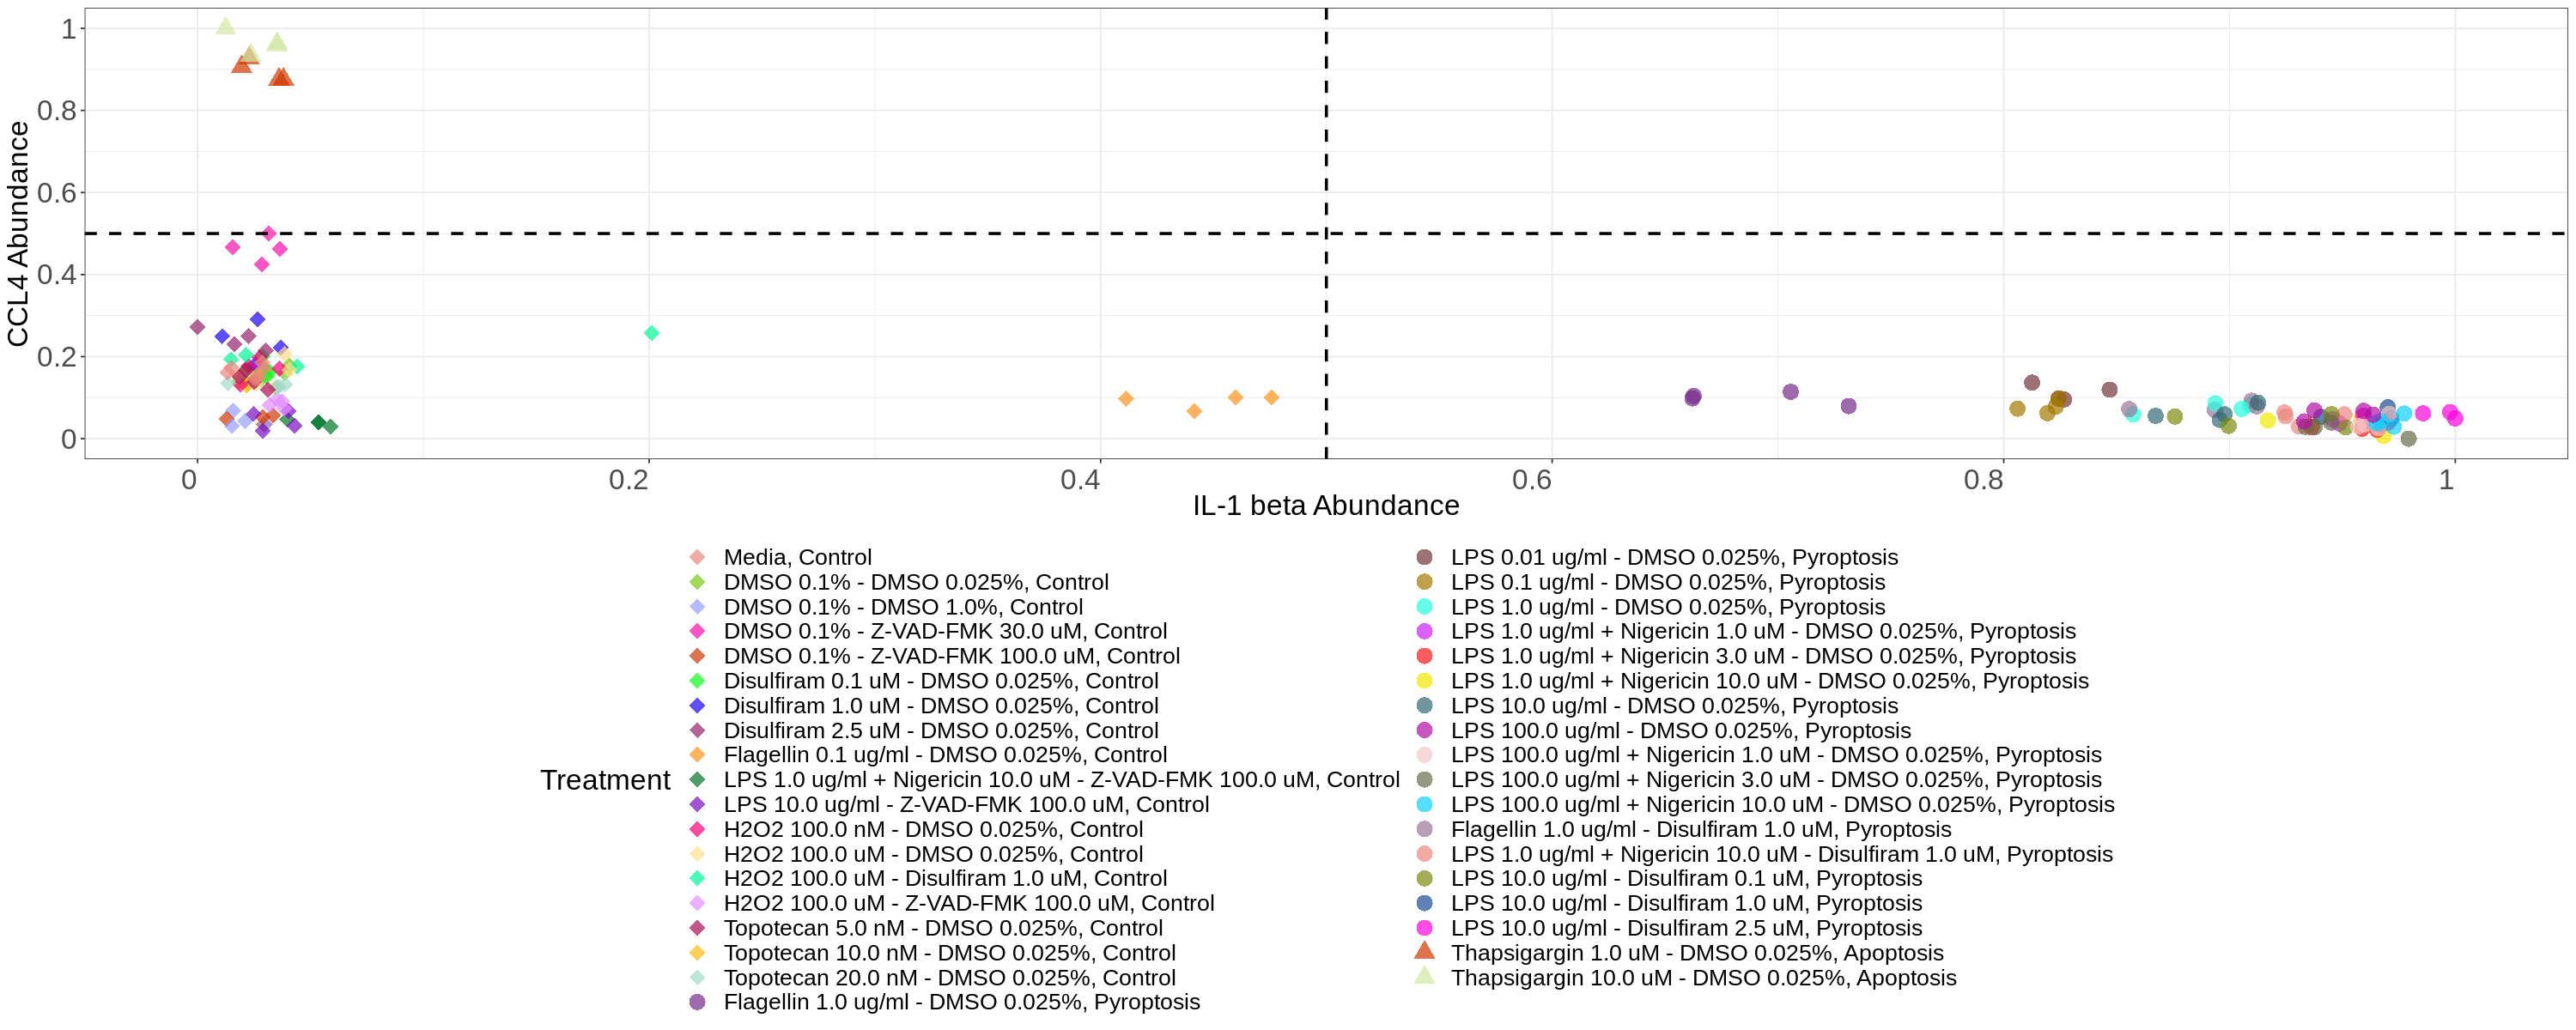

In [14]:
# set plot size
width <- 25
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
# set the pallette
custom_pallette = createPalette(37,  c("#ff0000", "#00ff00", "#0000ff"))
custom_pallette <- sortByHue(custom_pallette)
custom_pallette <- as.vector(t(matrix(custom_pallette, ncol=4)))

cytokine_scatter_plot1 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `CCL24 [NSU]`,
            color = group_treatment,
            shape = group_treatment
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta Abundance")
    + ylab("CCL4 Abundance")
    + xlim(-0.1, 1.1)
    + ylim(-0.1, 1.1)
    # x scale breaks
    + scale_x_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # y scale breaks
    + scale_y_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # rotate x axis text
    + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = custom_pallette)
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = c(
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16, 
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,

            17,
            17
        )
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    + guides(color = guide_legend(ncol = 2))
    

)
# cytokine_scatter_plot add gates 
cytokine_scatter_plot1 <- (
    cytokine_scatter_plot1
    + geom_vline(xintercept = 0.5, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
)
cytokine_scatter_plot1


Warning message in matrix(custom_pallette, ncol = 4):
“data length [37] is not a sub-multiple or multiple of the number of rows [10]”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


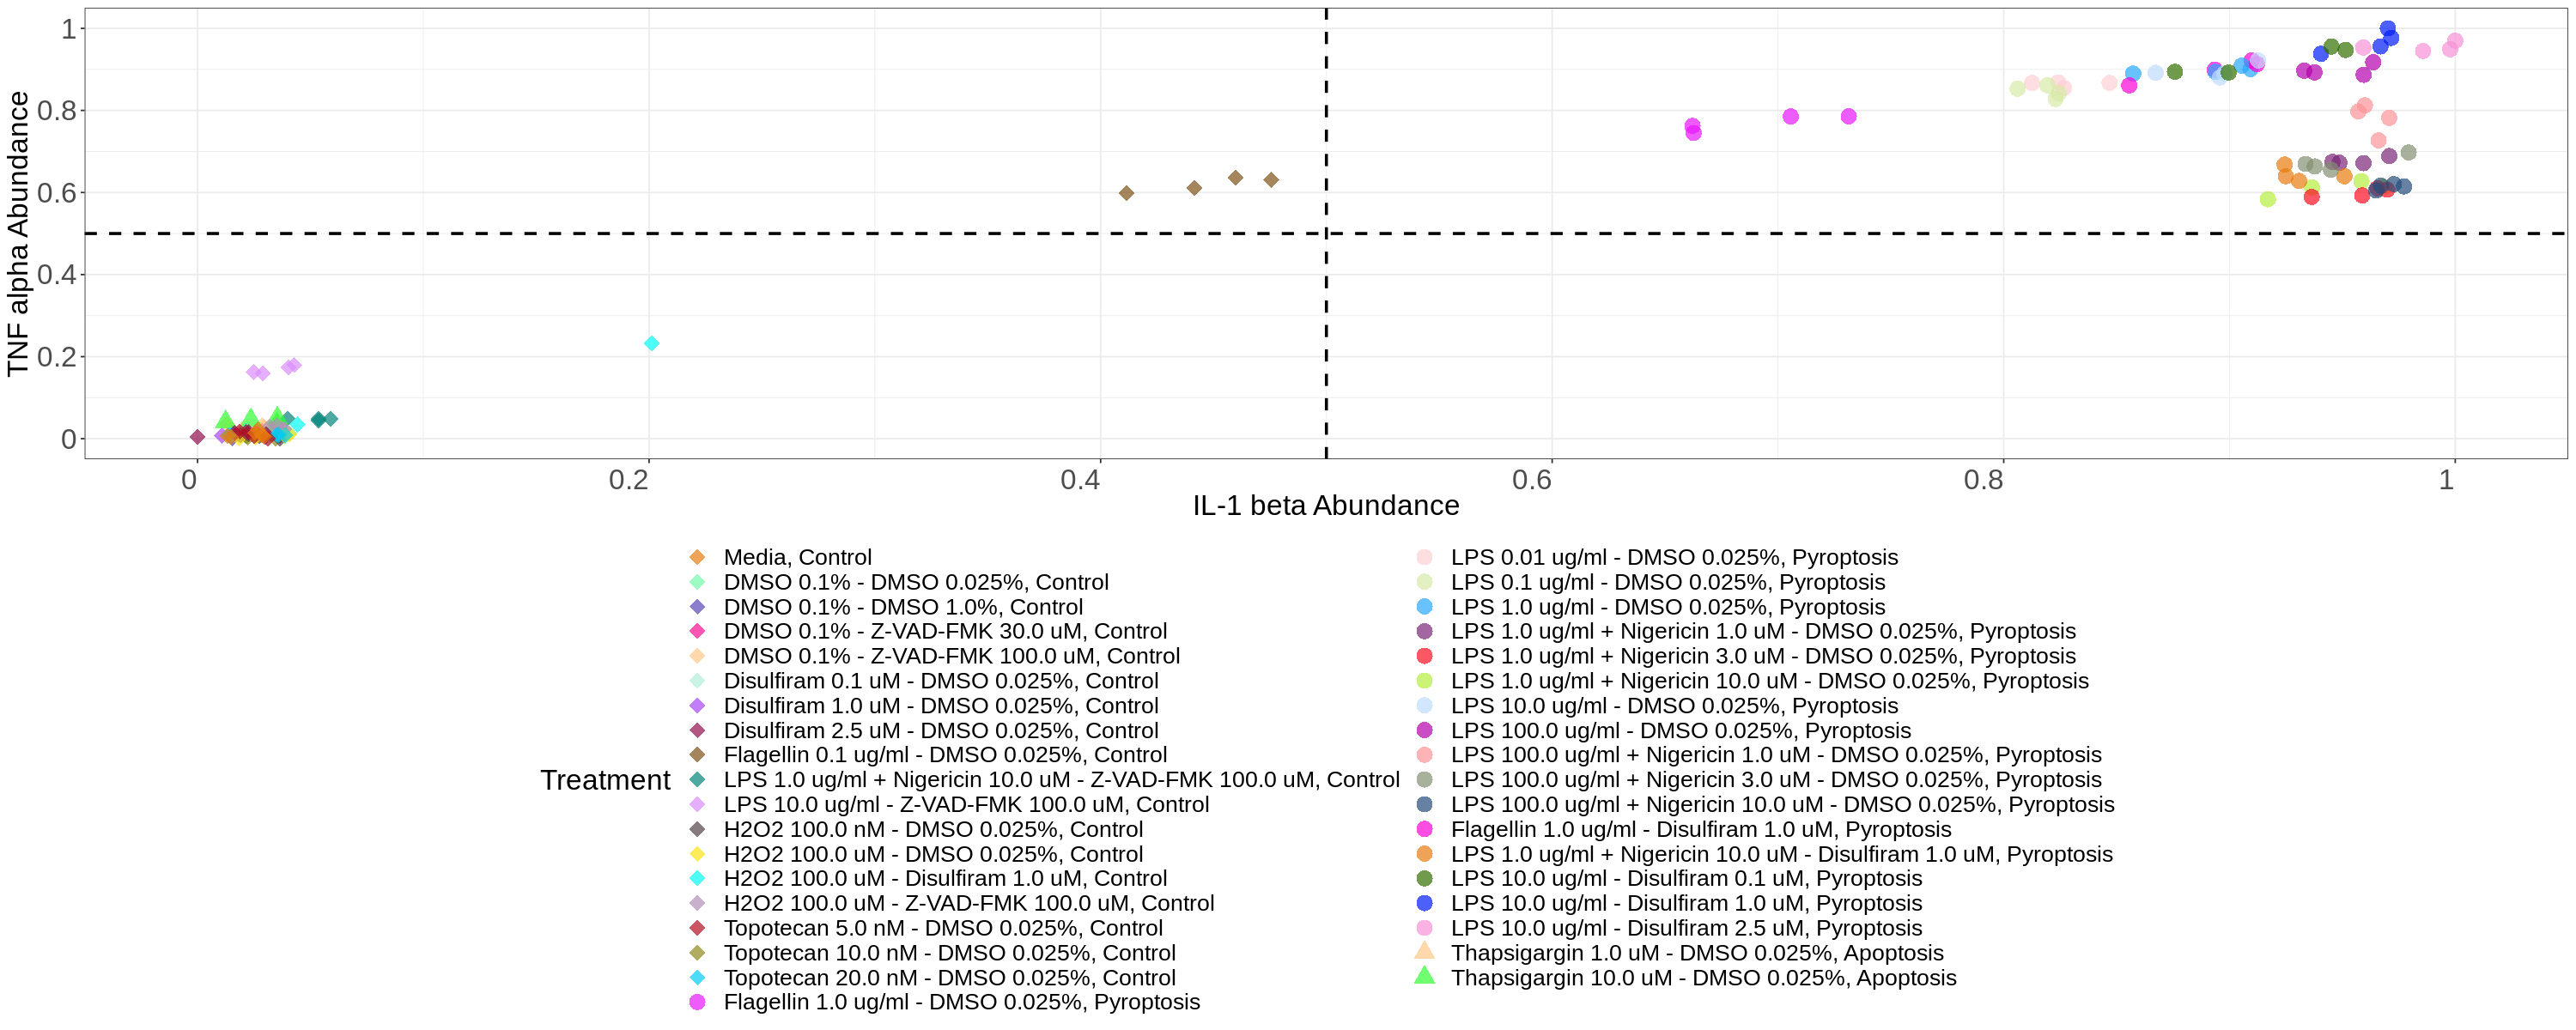

In [15]:
# set plot size
width <- 25
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
# set the pallette
# custom_pallette <- viridis::viridis_pal(option = "C")(length(unique(cytokine_values$group_treatment)))
custom_pallette = createPalette(37,  c("#ff0000", "#00ff00", "#0000ff"))
custom_pallette <- sortByHue(custom_pallette)
custom_pallette <- as.vector(t(matrix(custom_pallette, ncol=4)))

cytokine_scatter_plot2 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `TNF alpha [NSU]`,
            color = group_treatment,
            shape = group_treatment
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta Abundance")
    + ylab("TNF alpha Abundance")
    + xlim(-0.1, 1.1)
    + ylim(-0.1, 1.1)
    # x scale breaks
    + scale_x_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # y scale breaks
    + scale_y_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # rotate x axis text
    + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = custom_pallette)
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = c(
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16, 
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,

            17,
            17
        )
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    + guides(color = guide_legend(ncol = 2))
    

)
# cytokine_scatter_plot add gates 
cytokine_scatter_plot2 <- (
    cytokine_scatter_plot2
    + geom_vline(xintercept = 0.5, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
)
cytokine_scatter_plot2


### Heatmap of cytokine concentration

In [16]:
# import melted dataframes
# Figure 2A

# Load data
data_path_cytokine_values_melted <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.parquet")
cytokine_values_melted <- arrow::read_parquet(data_path_cytokine_values_melted)
# filter out the treatments that are not in the list
cytokine_values_melted <- subset(cytokine_values_melted, select = -Metadata_position_x)


In [17]:
# drop two columns by name 
# aggregate the cytokine values across the treatments and cytokine
cytokine_values_agg <- cytokine_values_melted %>%
    group_by(cytokine,oneb_Treatment_Dose_Inhibitor_Dose) %>%
    summarise_all(mean)


In [18]:
length(unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose))
# mutate the names of each treatment
cytokine_values_agg <- cytokine_values_agg %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% + DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% + Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml + DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml + DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml + Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml + Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'media_ctr_0.0_0_Media_0.0_0' ~ "Media",
        oneb_Treatment_Dose_Inhibitor_Dose == 'media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media"
    )
)
length(unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose))

[1] 40

[1] 39

In [19]:
length(unique(cytokine_values_agg$cytokine))
# gsub out '[NSU]' from the cytokine names
cytokine_values_agg$cytokine <- gsub('\\[NSU\\]', '', cytokine_values_agg$cytokine)
length(unique(cytokine_values_agg$cytokine))
    

[1] 187

[1] 187

In [20]:
# create a matrix of the cytokine values for the clustering and heatmap
# unmelt the data 
cytokine_values_agg <- reshape2::dcast(cytokine_values_agg, oneb_Treatment_Dose_Inhibitor_Dose ~ cytokine, value.var = "cytokine_value", fun.aggregate = mean)
# make oneb_Metadata_Treatment_Dose_Inhibitor_Dose the rownames
rownames(cytokine_values_agg) <- cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose
# drop the column
cytokine_values_agg <- subset(cytokine_values_agg, select = -c(oneb_Treatment_Dose_Inhibitor_Dose))


In [21]:
row_dend <- as.dendrogram(hclust(dist(cytokine_values_agg)))
col_dend <- as.dendrogram(hclust(dist(t(cytokine_values_agg))))


In [22]:
# remove '[NSU]' from the column names
colnames(cytokine_values_agg) <- gsub("\\[NSU\\]", "", colnames(cytokine_values_agg))


In [23]:
cytokine_values_agg <- as.matrix(cytokine_values_agg)


png 
  2

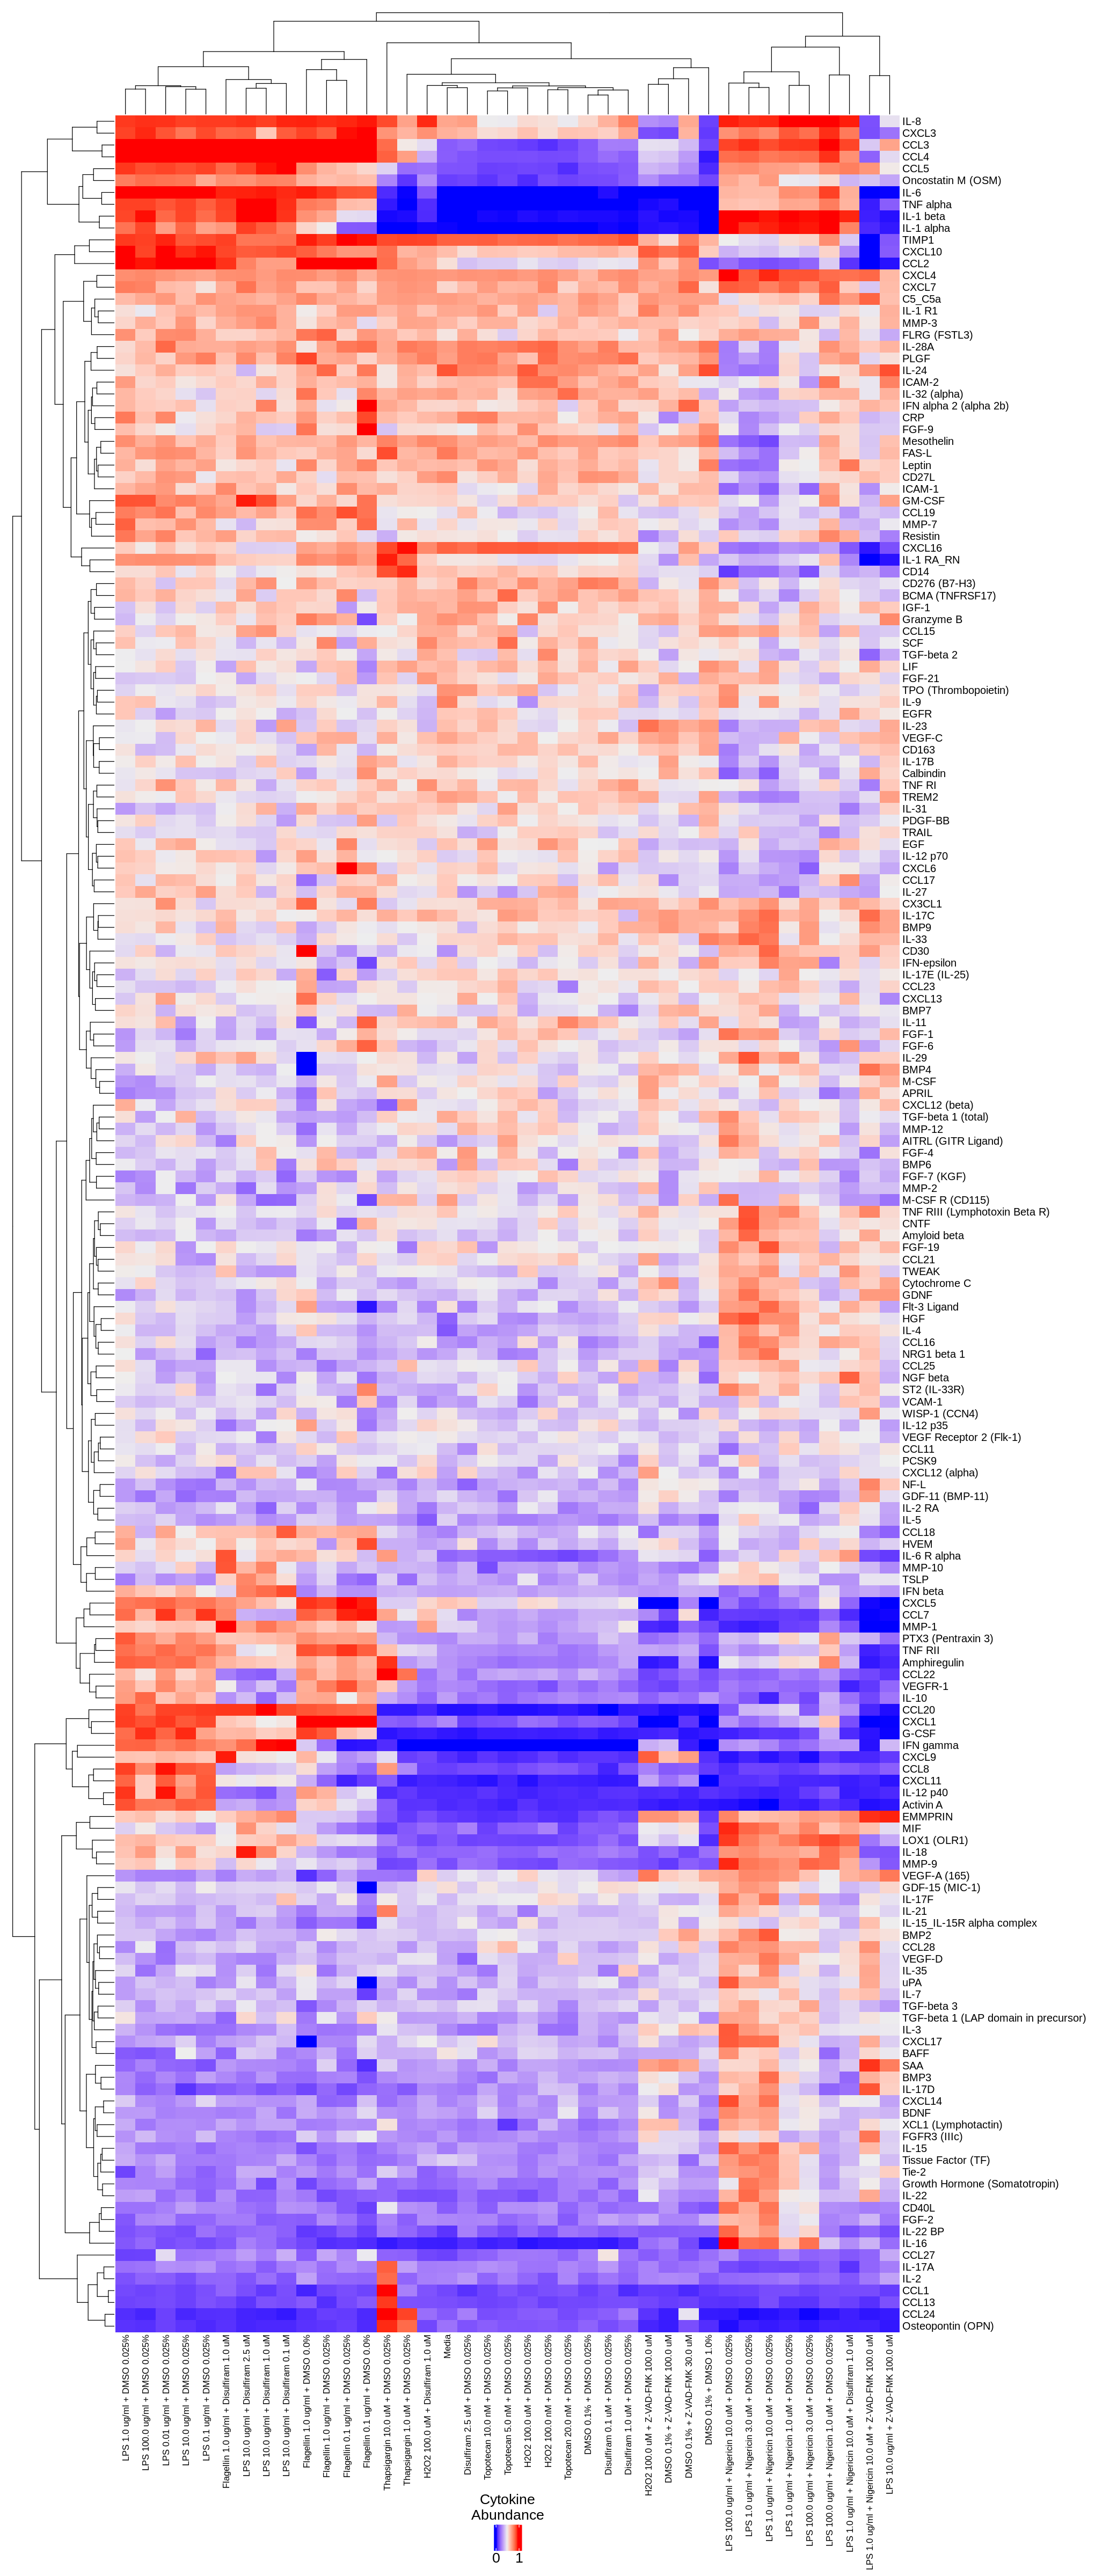

In [24]:
# set plot size 
width <- 17
height <- 40
options(repr.plot.width=width, repr.plot.height=height)
heatmap_plot_all <- (
  Heatmap(
  t(cytokine_values_agg),
  cluster_rows = TRUE,    # Cluster rows
  cluster_columns = TRUE, # Cluster columns
  show_row_names = TRUE,  # Show row names
  show_column_names = TRUE, # Show column names
  column_names_gp = gpar(fontsize = 10), # Column name label formatting
  row_names_gp = gpar(fontsize = 12),    # Row name label formatting
   heatmap_legend_param = list(
                title = "Cytokine\nAbundance", at = c(0, 1), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16), 
                labels_gp = gpar(fontsize = 16),
                direction = "horizontal",
                padding = unit(c(10, 10, 5, 5), "mm"),
                grid_width = unit(5000, "mm"),
                grid_height = unit(10, "mm")
                ),
  # make the tiles rectangular
  rect_gp = gpar(col = NA),
  column_dend_height = unit(4, "cm"), 
  row_dend_width = unit(4, "cm")
    )
)

heatmap_plot_all <- draw(
    heatmap_plot_all, 
    heatmap_legend_side = "bottom", 
    annotation_legend_side = "right",
    # change locaiton of the legend
    merge_legend = TRUE,
    padding = unit(c(5, 5, 5, 15), "mm"),
)


png(file.path("..","figures","all_cytokines_heatmap.png"), width = width, height = height, units = "in", res = 600)
heatmap_plot_all
dev.off()
heatmap_plot_all


rastergrob[GRID.rastergrob.1563] 

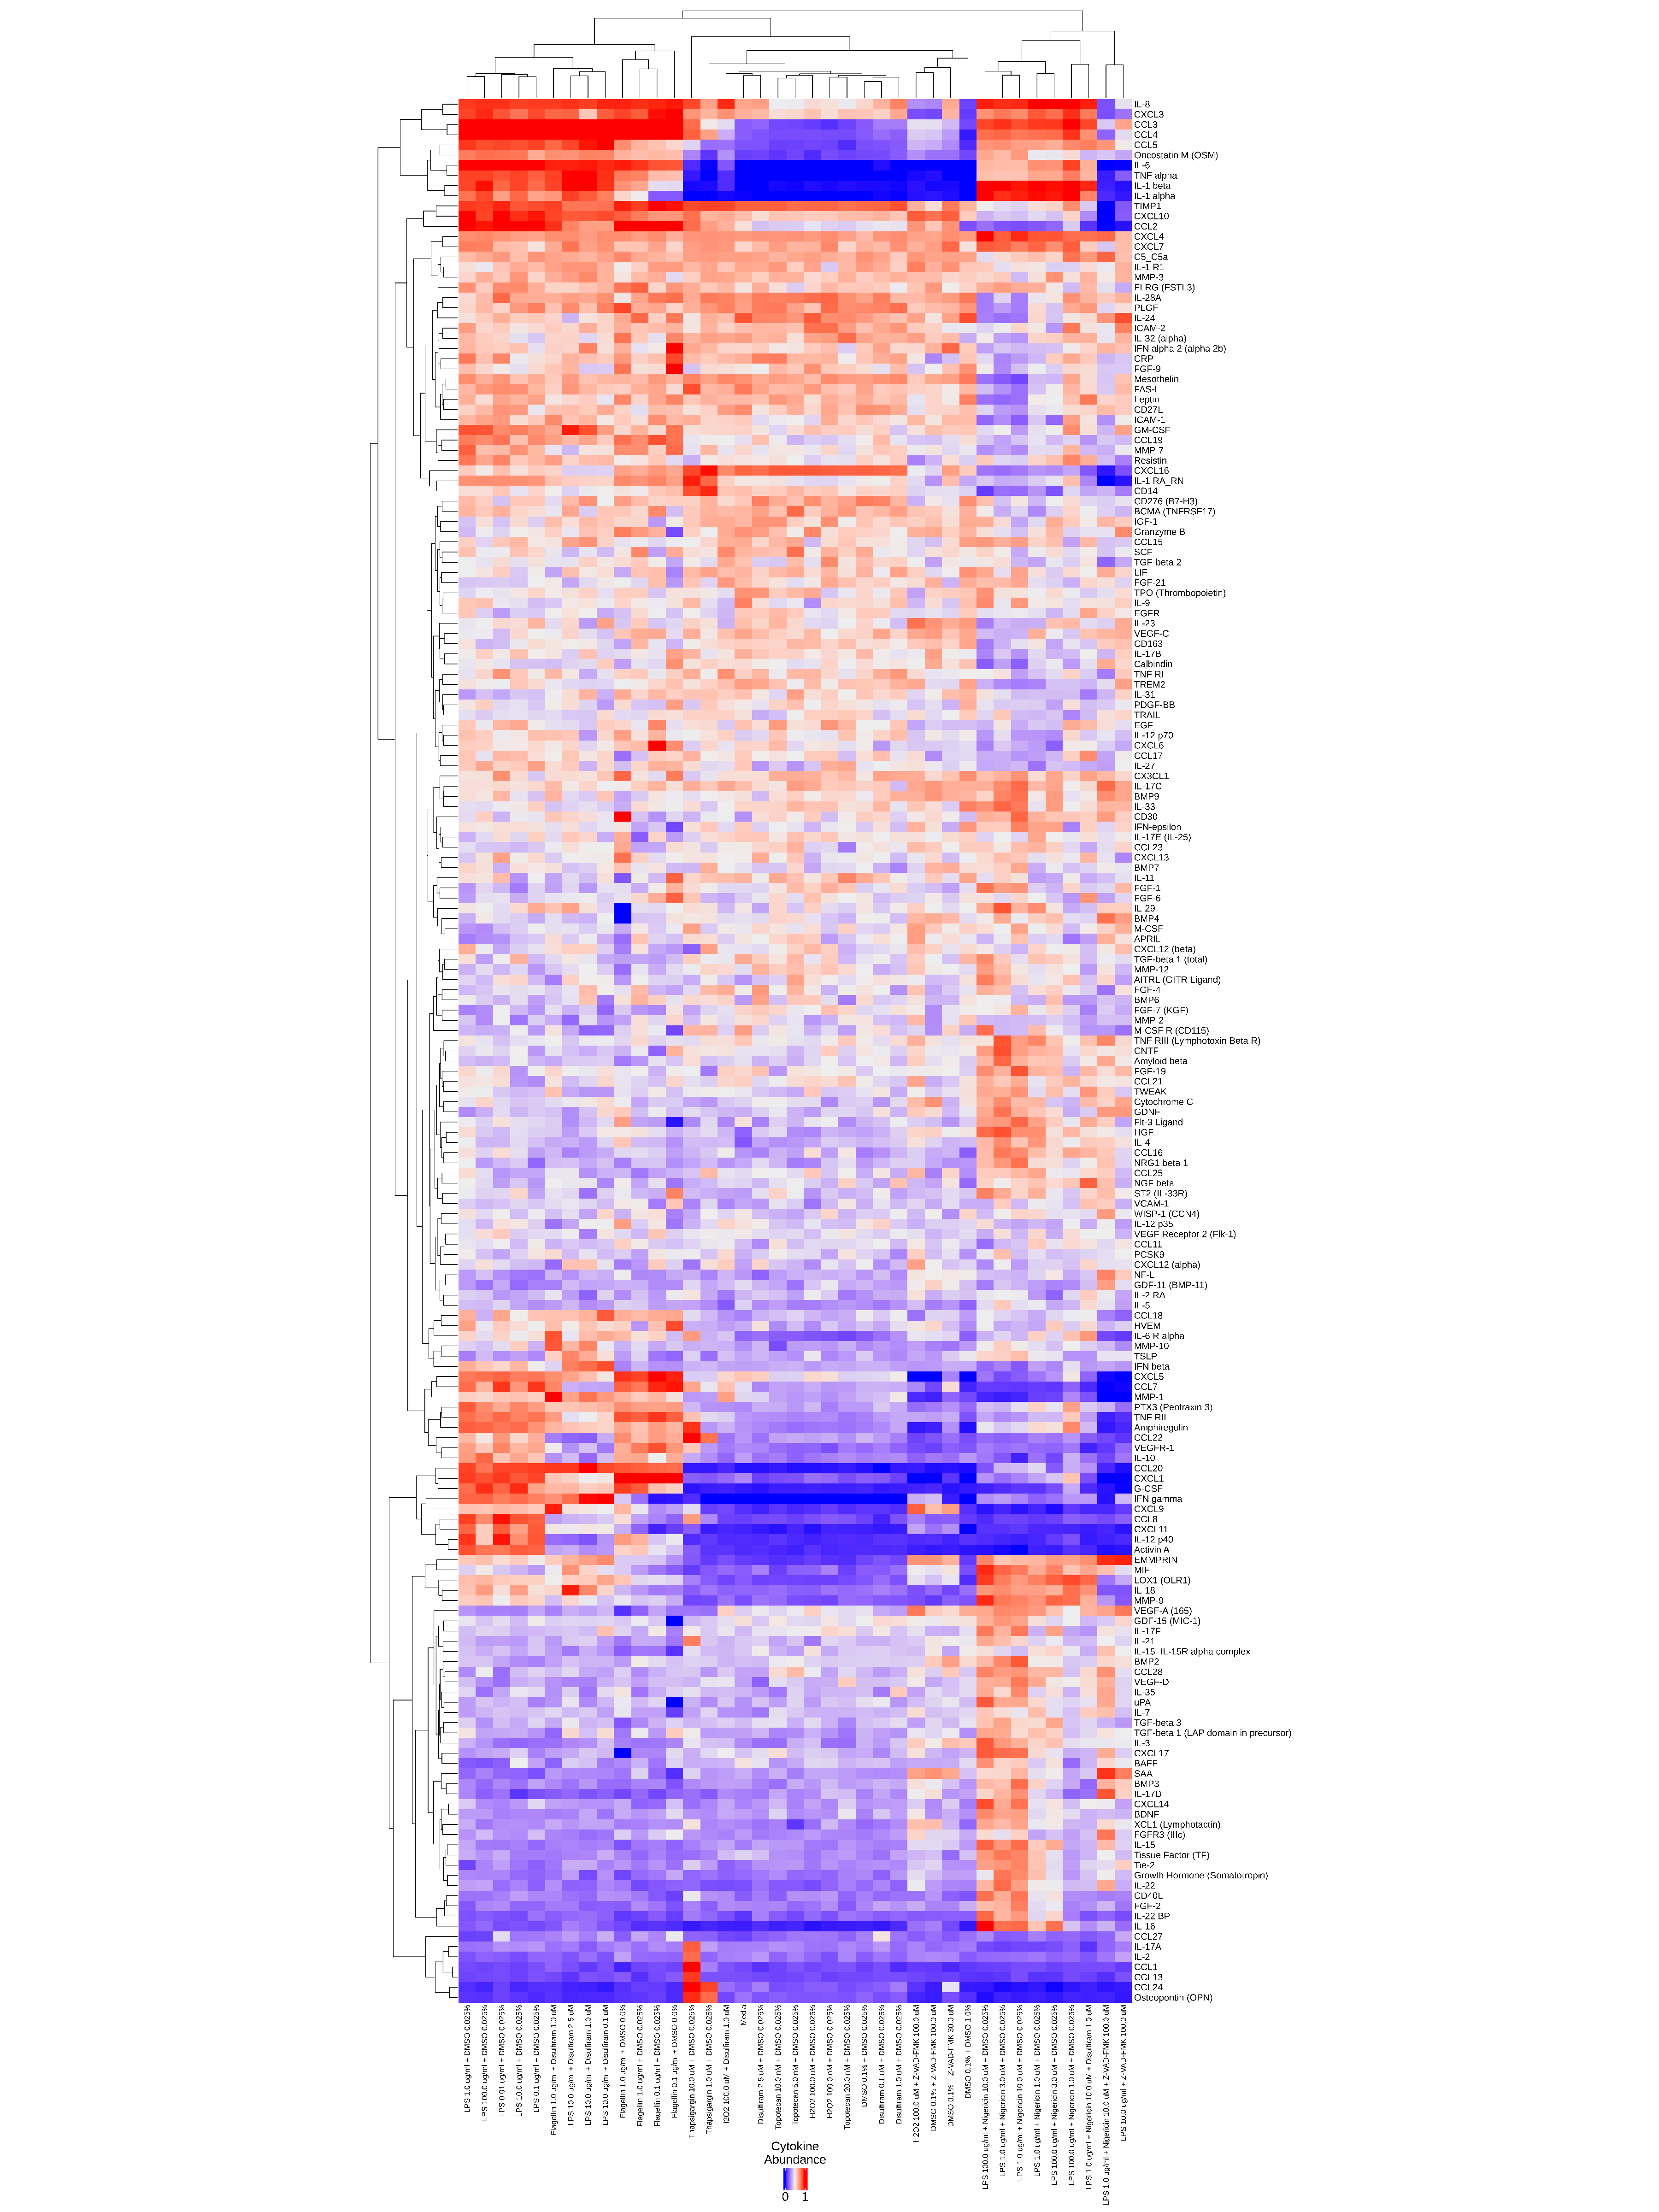

In [25]:
# load in the png to a grob object
heatmap_grob <- png::readPNG(file.path("..","figures","all_cytokines_heatmap.png"))
# convert the grob object to a raster grob
heatmap_cytokines <- rasterGrob(heatmap_grob, interpolate = TRUE)

# heatmap_anova_cytokines
heatmap_cytokines
# # Defien the heatmap as a ggplot heatmap for figure curation
# set plot size
width <- 30
height <- 40
options(repr.plot.width=width, repr.plot.height=height, units = "in")
heatmap_cytokines <- as.ggplot(heatmap_cytokines) 
heatmap_cytokines


## UMAP Plots

In [26]:
# read in the UMAP results
umap_results_path <- file.path("..","..","..","2.Nomic_nELISA_Analysis/1.umap/PBMC/results/nELISA_plate_430420_umap_PBMC.csv")
# read in the data
umap_results <- read.csv(umap_results_path, header = TRUE, sep = ",")
length(unique(umap_results$oneb_Treatment_Dose_Inhibitor_Dose))

[1] 40

In [27]:
# convert to a dataframe
umap_results <- as.data.frame(umap_results)

# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%
umap_results$oneb_Treatment_Dose_Inhibitor_Dose <- ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.0_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", umap_results$oneb_Treatment_Dose_Inhibitor_Dose)
umap_results$oneb_Treatment_Dose_Inhibitor_Dose <- ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", "Flagellin_1.000_ug_per_ml_DMSO_0.025_%", umap_results$oneb_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
umap_results$group <- ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
umap_results$group <- factor(umap_results$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [28]:
# mutate the names of each treatment

umap_results <- umap_results %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
umap_results$oneb_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media", umap_results$oneb_Treatment_Dose_Inhibitor_Dose)


In [29]:
# create grouping of treatment and group
umap_results$group_treatment <- paste(umap_results$oneb_Treatment_Dose_Inhibitor_Dose, umap_results$group,  sep = ", ")
# make the group_treatment column a factor
umap_results$group_treatment <- factor(
    umap_results$group_treatment, 
        levels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
    
)
    )


Warning message in matrix(custom_pallette, ncol = 4):
“data length [39] is not a sub-multiple or multiple of the number of rows [10]”


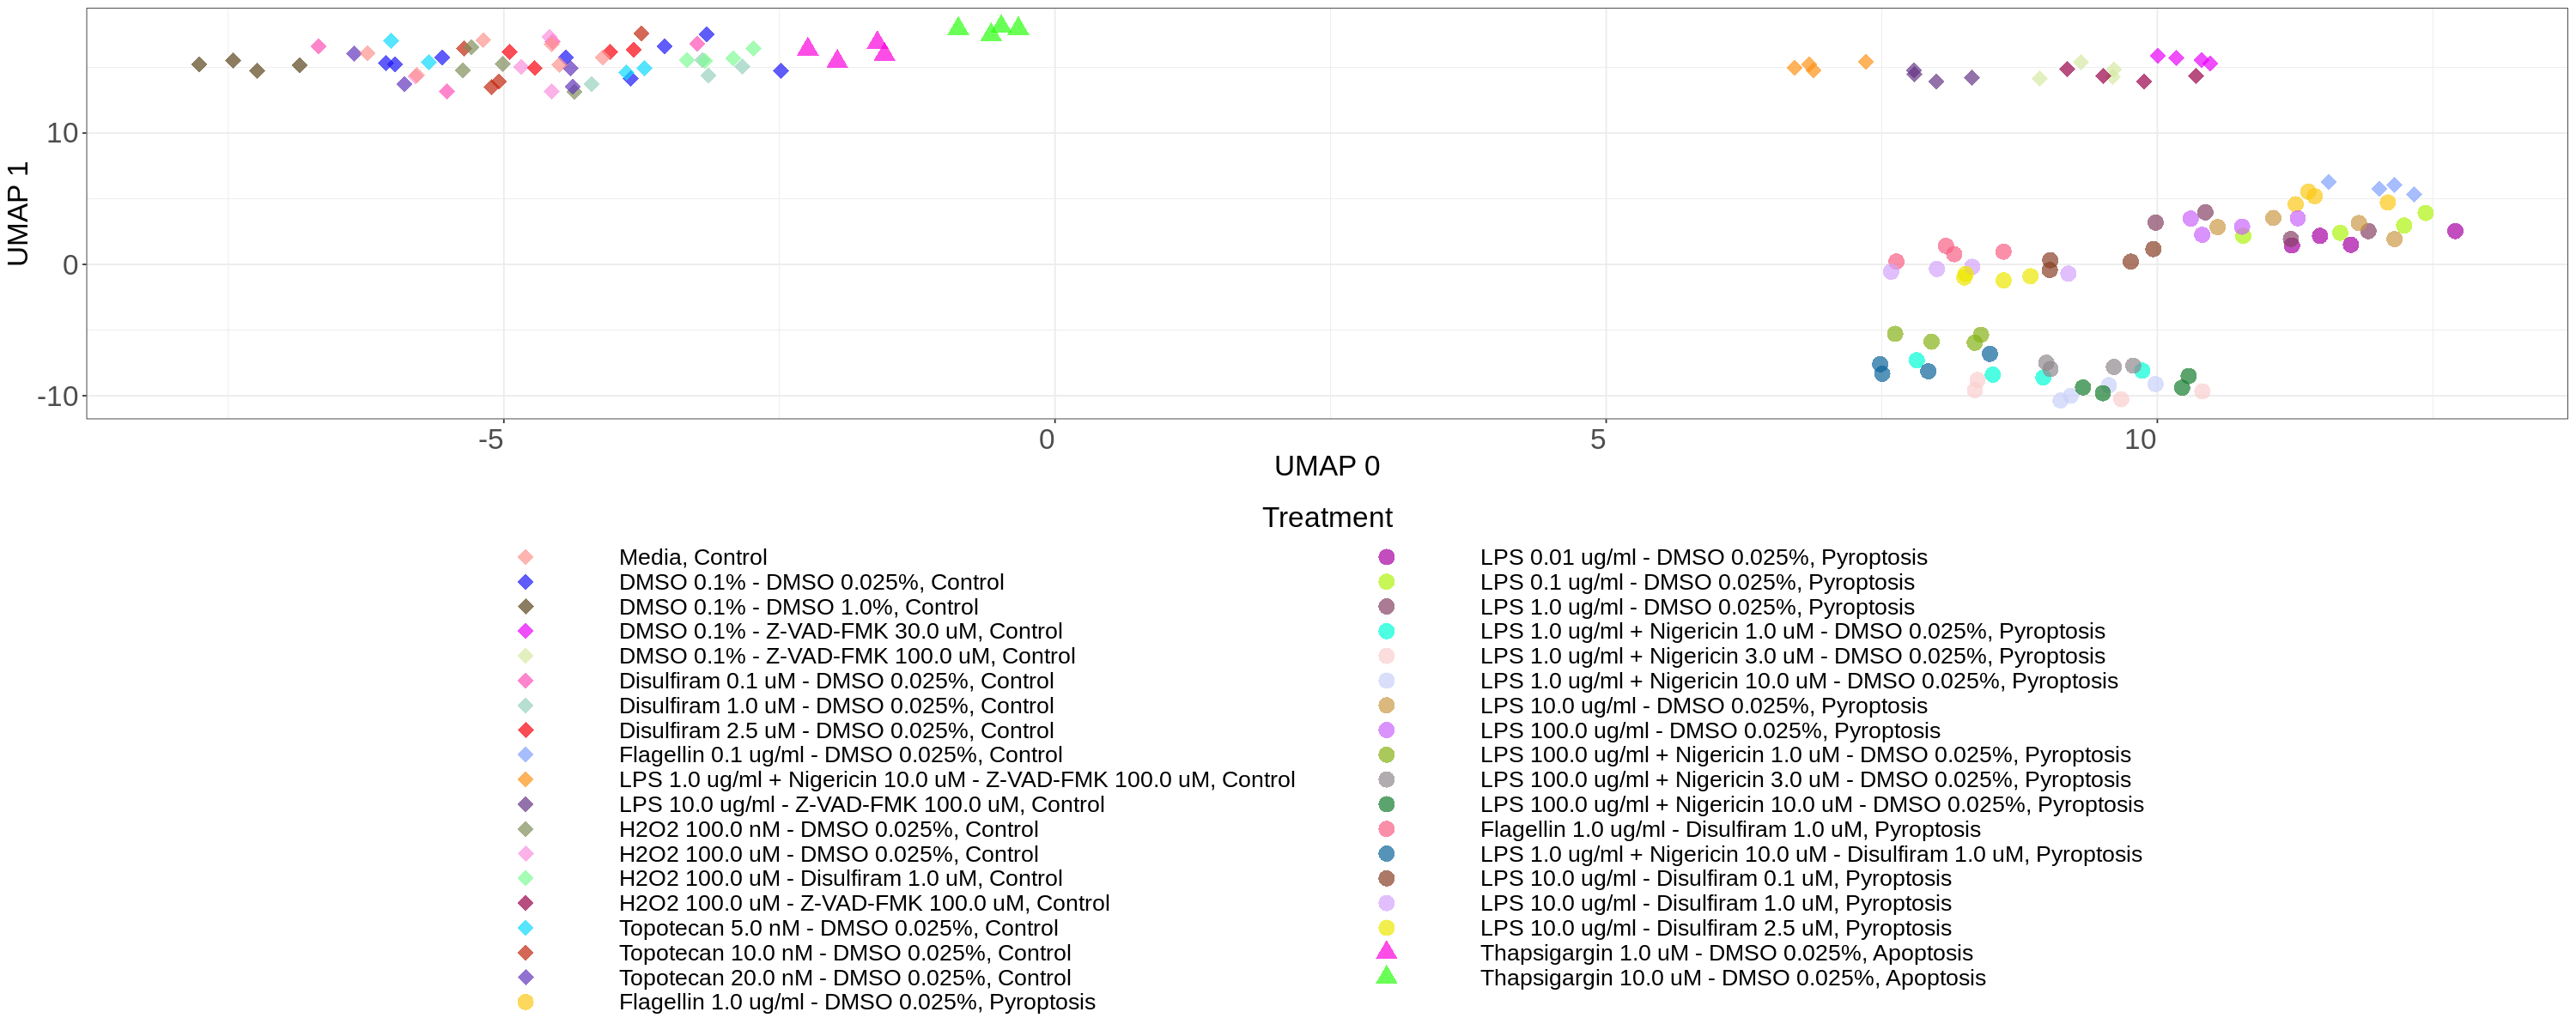

In [50]:
# set plot size
width <- 25
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
# set the pallette
custom_pallette = createPalette(39,  c("#ff0000", "#00ff00", "#0000ff"))
custom_pallette <- sortByHue(custom_pallette)
custom_pallette <- as.vector(t(matrix(custom_pallette, ncol=4)))

custom_pallette <- as.vector(t(matrix(custom_pallette, ncol=4)))

UMAP_plot <- (
    ggplot(
        data = umap_results,
        aes(
            x = umap_1,
            y = umap_2,
            color = group_treatment,
            shape = group_treatment
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("UMAP 0")
    + ylab("UMAP 1")
    # rotate x axis text
    + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = custom_pallette)
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = c(
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16, 
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,

            17,
            17
        )
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 2
    + guides(color = guide_legend(
        title.position = "top",
        ncol = 2))
    # add space between legend columns
    + theme(legend.spacing.x = unit(2, 'cm'))
)

UMAP_plot


## Patch the plots  together 

In [51]:
# show the plots first as assigned names
# set plot size 
options(repr.plot.width=5, repr.plot.height=5)


In [52]:

# add padding to scatter plot
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + theme(plot.margin = unit(c(1,0,0,0), "cm"))
cytokine_scatter_plot2 <- cytokine_scatter_plot2 + theme(plot.margin = unit(c(1,0,0,0), "cm"))

# remove the legend
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + theme(legend.position = "none")
cytokine_scatter_plot2 <- cytokine_scatter_plot2 + theme(legend.position = "none")
# add padding to the umap
UMAP_plot <- UMAP_plot + theme(plot.margin = unit(c(1,0,0,0), "cm"))
# heatmap_cytokines
# set plot size
width <- 5
height <- 5
options(repr.plot.width=width, repr.plot.height=height, units = "cm")
cytokine_scatter_plot1 <- as.ggplot(cytokine_scatter_plot1)
cytokine_scatter_plot2 <- as.ggplot(cytokine_scatter_plot2)
UMAP_plot <- as.ggplot(UMAP_plot)



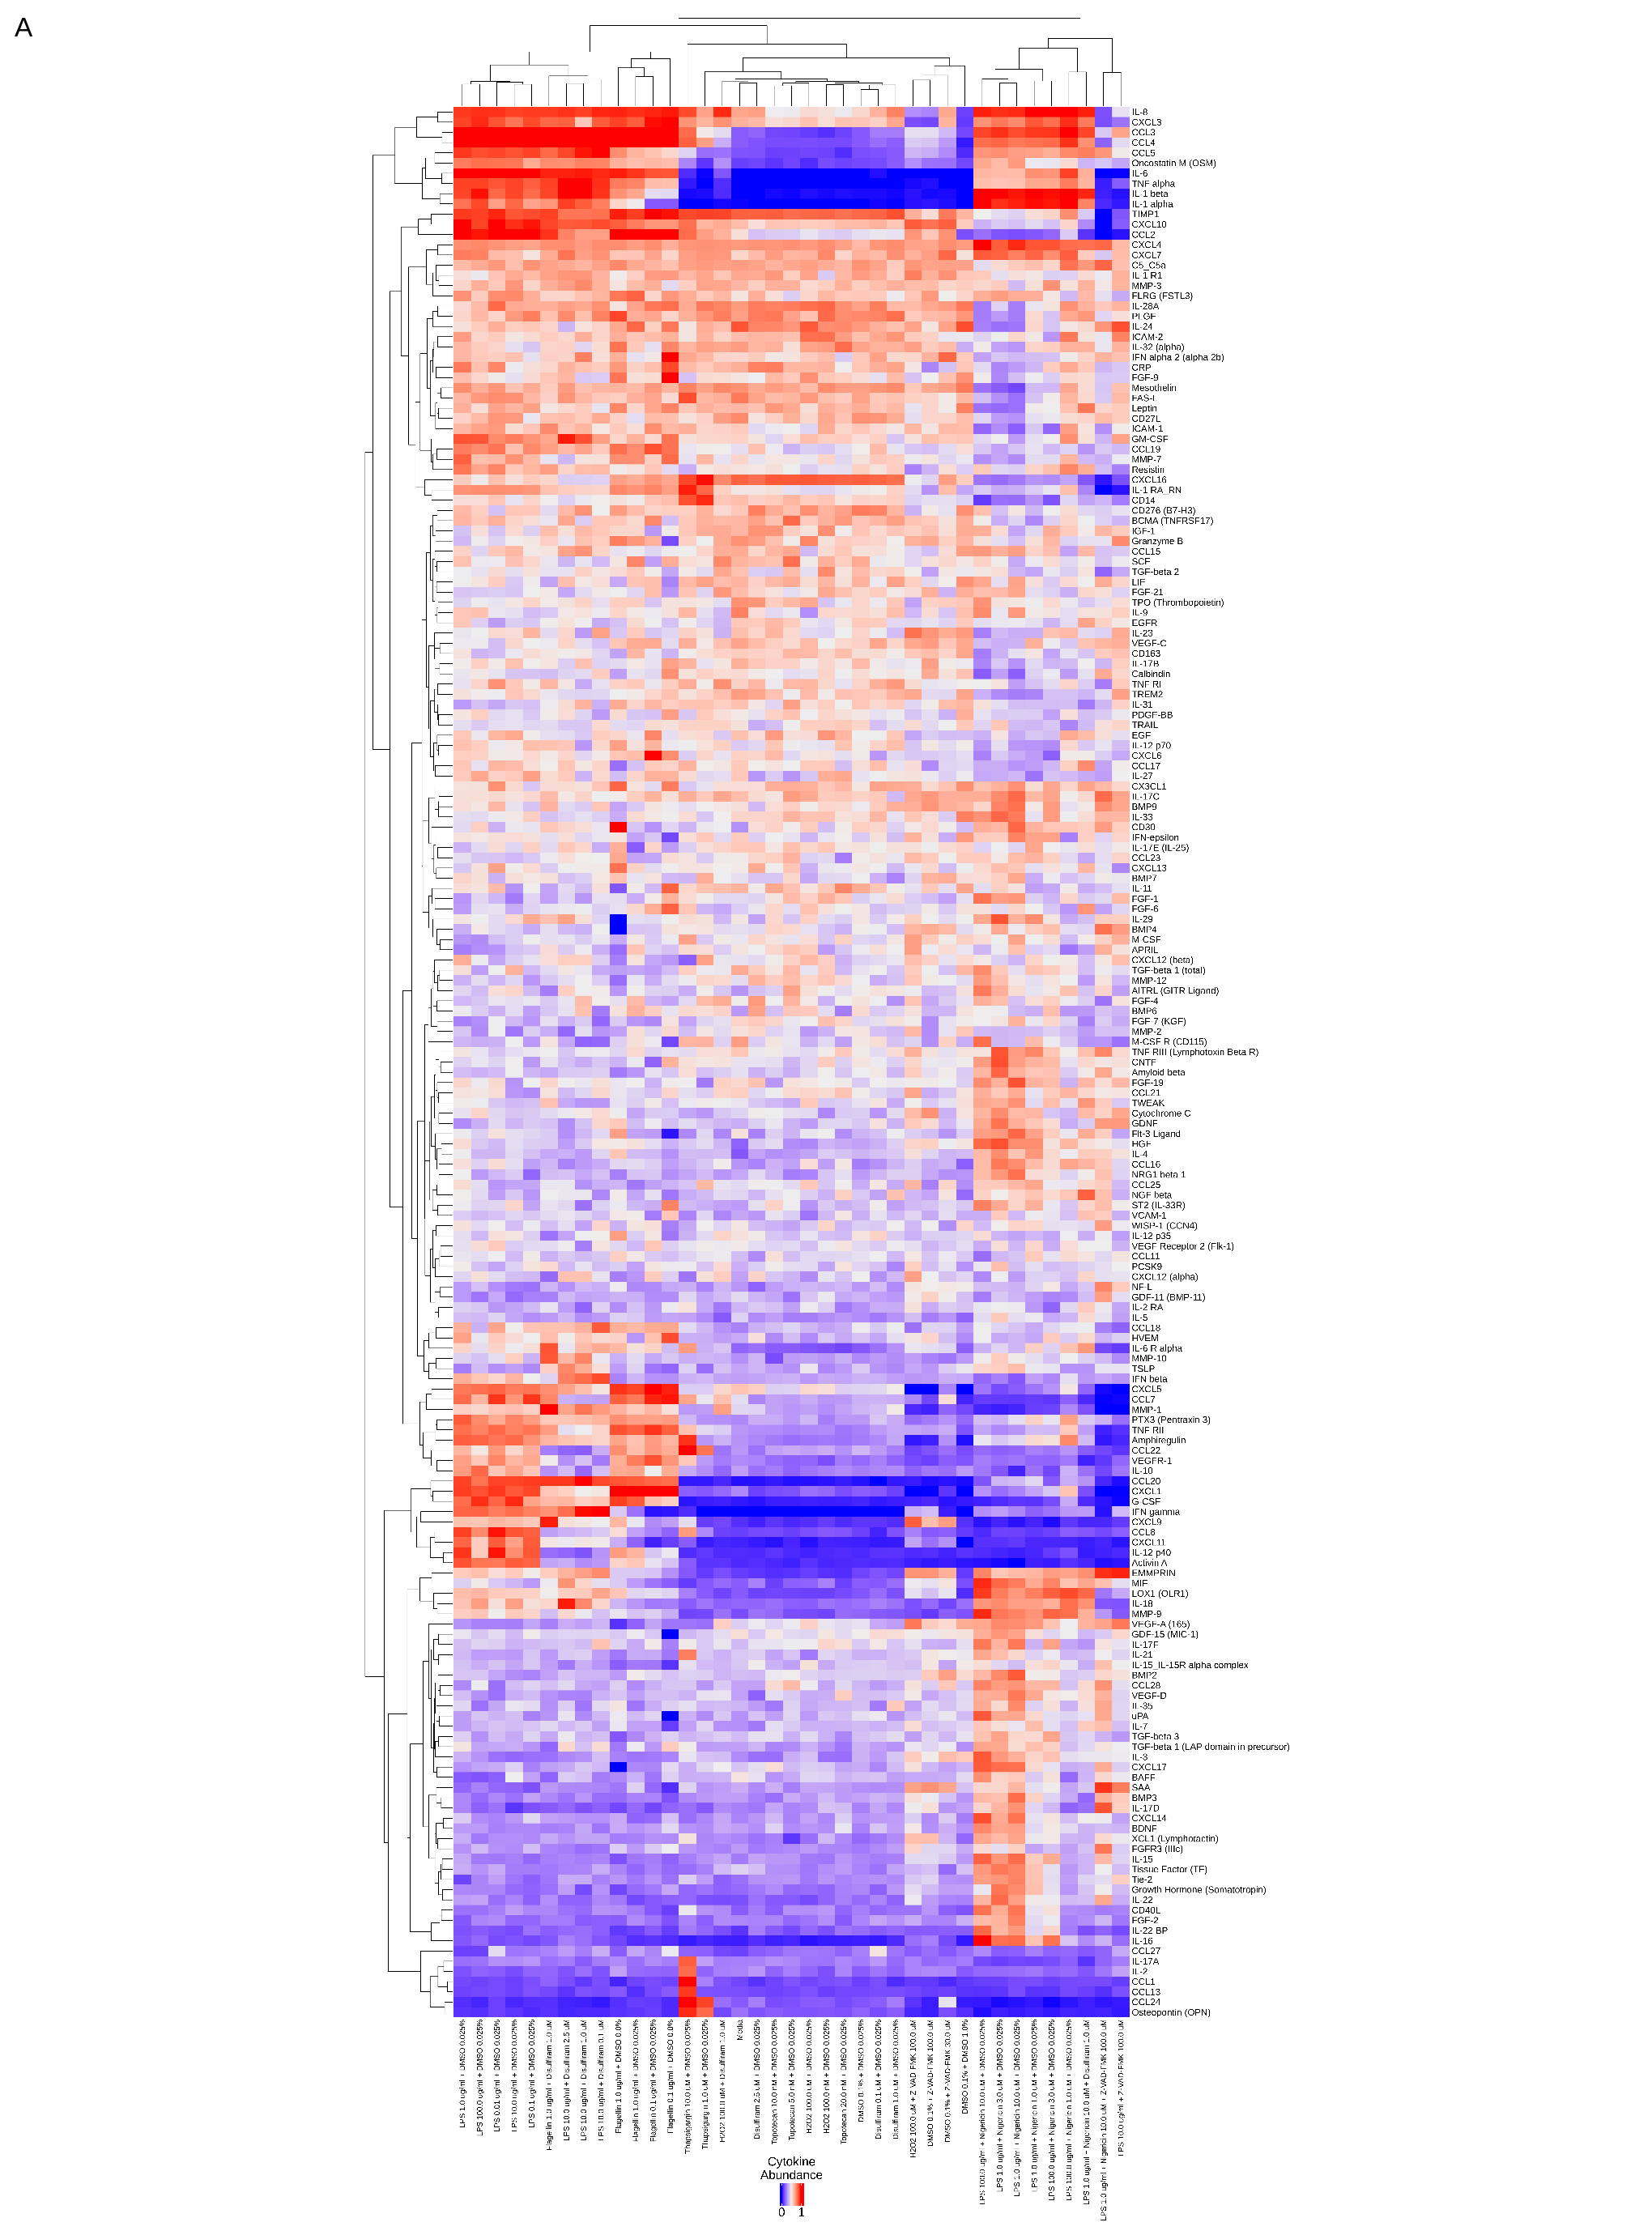

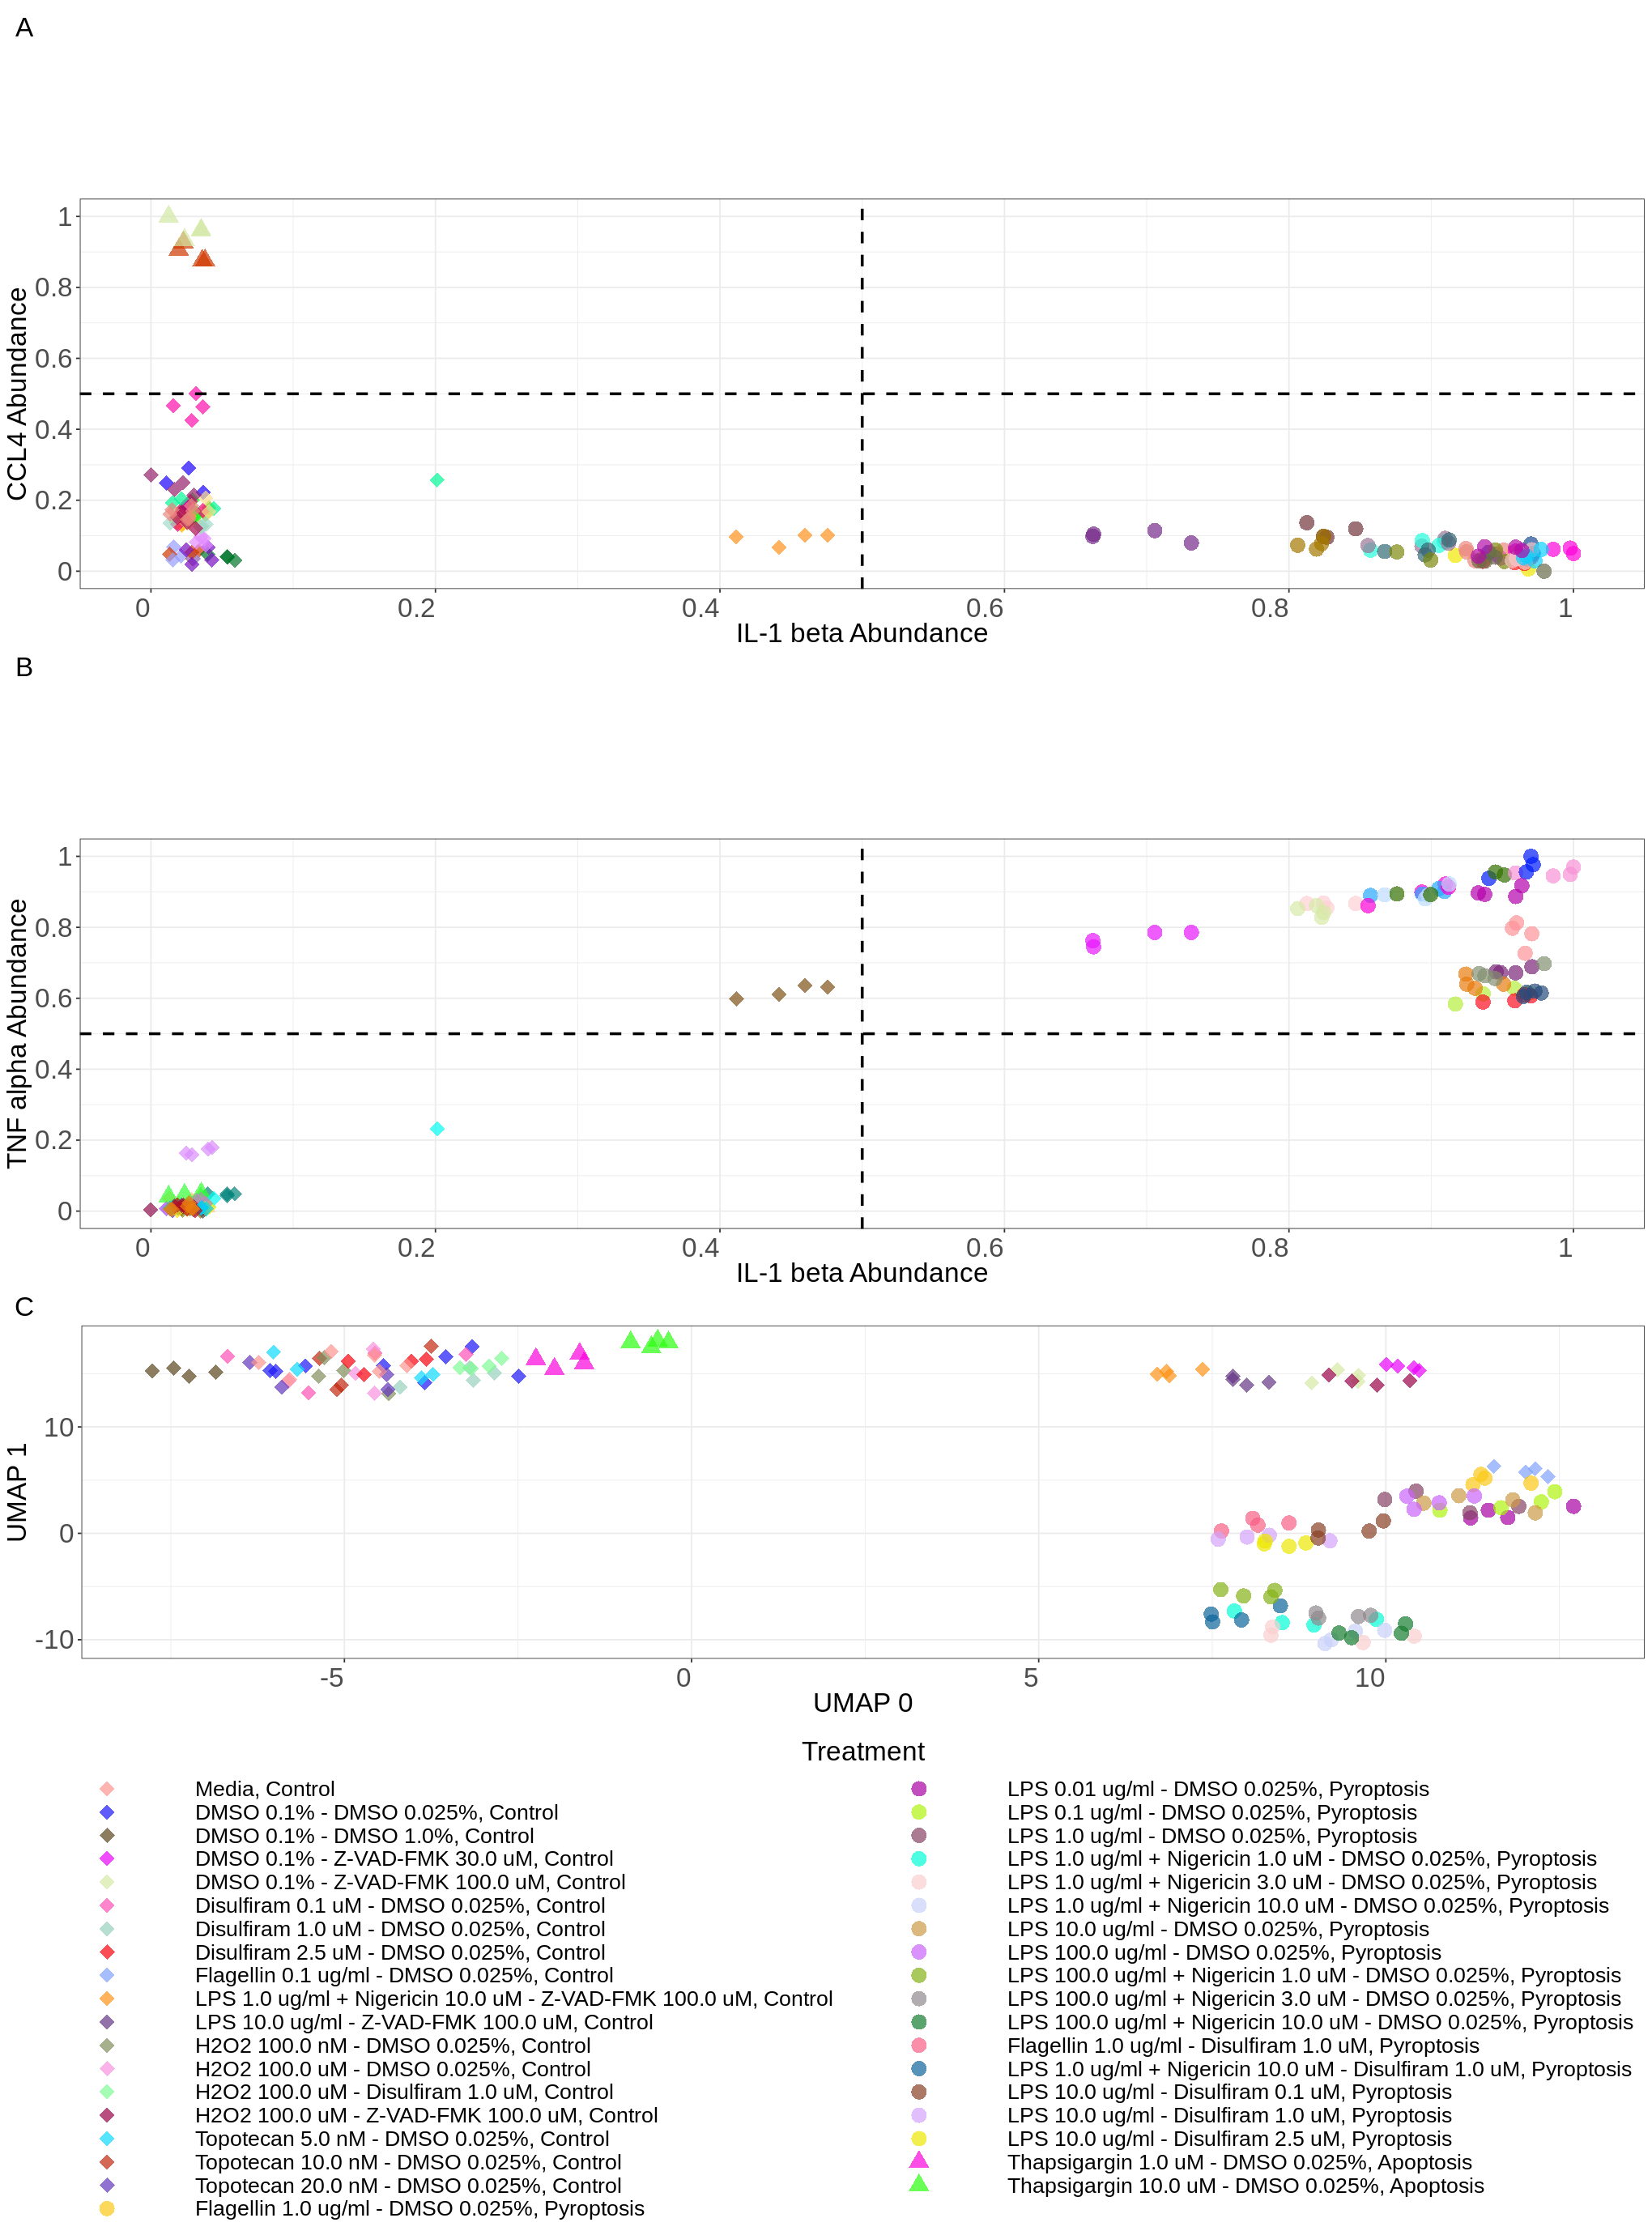

In [53]:
# set the design of the plots in the figure
# Where each letter represents a plot by order defined and the # represents a blank space
# each row represents a proportion of the total plot size
# some plots may be on multiple rows or columns
# plots can be proportioned by adding more letters to the row or column
design <-  "AAAA
            AAAA
            BBBB
            BBBB
            CCCC
            CCCC
            CCCC
            "

# set plot size
width <- 17
height <- 23
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)

# sfig_pt1
sfig_pt1 <- (
    wrap_elements(full = heatmap_cytokines)
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
sfig_pt1

# sfig_pt2
sfig_pt2 <- (
    wrap_elements(full = cytokine_scatter_plot1)
    + wrap_elements(full = cytokine_scatter_plot2)
    + wrap_elements(full = UMAP_plot)
    + plot_layout(design = design, widths = c(0.3,15), heights = c())
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
sfig_pt2

# save the figure
ggsave(
    filename = file.path("..","figures","final_figure_pt1.png"),
    plot = sfig_pt1,
    width = width,
    height = height,
    dpi = 600
)
ggsave(
    filename = file.path("..","figures","final_figure_pt2.png"),
    plot = sfig_pt2,
    width = width,
    height = height,
    dpi = 600
)
